## Send MWA data to JSON format for training

In [1]:
import sys
sys.path.append('/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/python/')
from utils import *

import numpy as np
import yaml
import os
import glob
import json
from astropy.io import fits
import h5py
import matplotlib.pyplot as plt
from mapper import bg_subtract
plt.style.use('seaborn-v0_8')

In [3]:
# Get data
dirpath = '/users/jmduchar/data/jmduchar/Research/mcgill25/ssins_data/'
# reference_obs = '1093799552'  # known to contain RFI
# reference_obs = '1094662784'
reference_obs = '1090867840'

with open(dirpath+'gridpoint_dict.yaml', 'r') as file:
    data = yaml.safe_load(file)
    
pointing, obsids = get_night(data=data, target_obsid=reference_obs)
# obsids = get_pointing(data, pointing=0)
# obsids.sort()

len(obsids)

15

In [4]:
subtracted_data = bg_subtract(data_dir=dirpath+'tars/', obsids=obsids, N_terms=22)
subtracted_data = subtracted_data[~np.isnan(subtracted_data)]

subtracted_data.shape

channel_width not available in file, computing it from the freq_array spacing.
Antenna metadata are missing for this file. Since this is MWA data, the best way to fill in these metadata is to pass in an mwa_metafits_file which contains information about which antennas were connected when the data were taken. Since that was not passed, the antenna metadata will be filled in from a static csv file containing all the antennas that could have been connected.
channel_width not available in file, computing it from the freq_array spacing.
Antenna metadata are missing for this file. Since this is MWA data, the best way to fill in these metadata is to pass in an mwa_metafits_file which contains information about which antennas were connected when the data were taken. Since that was not passed, the antenna metadata will be filled in from a static csv file containing all the antennas that could have been connected.
invalid value encountered in multiply
invalid value encountered in divide
sig_arra

(750,)

In [5]:
cb = np.load('../data/coarse_bands_1D.npy')
ssins_list = []

for obsid in obsids:
    file = dirpath + f"tars/{obsid}_SSINS_data.h5"
    
    with h5py.File(file, "r") as hf:
        
        # Access the SSINS
        ssins_rep = hf['Data']['metric_array'][:][:,:,0]  # xx polarization
        
        # Remove CB
        ssins_rep = ssins_rep[:,np.invert(cb)]
        
        # Avg across DTV7
        ssins_rep = np.mean(ssins_rep[:,350:525], axis=1)

        # Remove inf
        ssins_rep = ssins_rep[~np.isinf(ssins_rep)]

        # Append to list
        ssins_list.append(ssins_rep)

In [6]:
ssins = np.asarray(ssins_list).flatten()
ssins -= np.median(ssins)

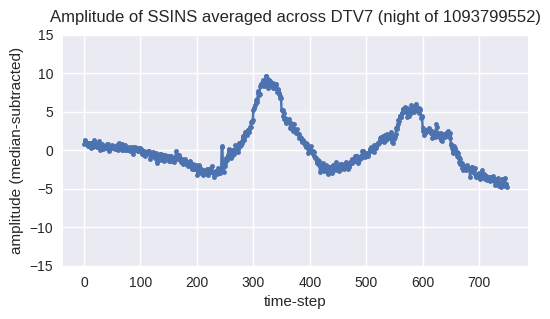

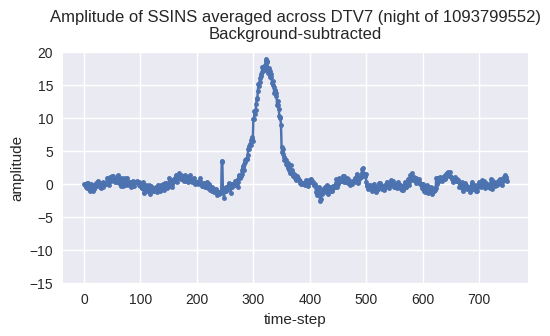

In [7]:
plt.figure(figsize=(6,3))
plt.plot(ssins, '.-')
plt.title("Amplitude of SSINS averaged across DTV7 (night of 1093799552)", y=1.02)
plt.xlabel("time-step")
plt.ylabel("amplitude (median-subtracted)")
# plt.yscale('symlog')
plt.ylim(-15,15)
# plt.savefig("./sample.png",dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=(6,3))
plt.plot(subtracted_data, '.-')
plt.title("Amplitude of SSINS averaged across DTV7 (night of 1093799552)\nBackground-subtracted", y=1.02)
plt.xlabel("time-step")
plt.ylabel("amplitude")
# plt.yscale('symlog')
plt.ylim(-15,20)
# plt.savefig("./sample.png",dpi=300,bbox_inches='tight')
plt.show()

In [8]:
# Structure the data for Stan
stan_data = {
    "N": subtracted_data.shape[0],
    "y": subtracted_data.tolist(),
}

In [9]:
stan_data

{'N': 750,
 'y': [-0.1115634309168172,
  -0.01314209947247491,
  -0.14237401040713848,
  -0.2562657378972517,
  -0.500644525597636,
  -0.5845456643503439,
  0.17091863778966854,
  0.036292855288479586,
  -0.8573870026215218,
  -0.5771506815397061,
  -1.1390042711658452,
  -0.6163315747498928,
  -0.31147307982064376,
  -0.01857365132252653,
  -0.9944402584355885,
  -1.1367738440549147,
  -0.644328377233137,
  -0.8162404802260426,
  -0.1385724538370141,
  -0.2318874160237101,
  -0.555426214384056,
  -0.305242333335741,
  0.13662207041659258,
  -0.12259445248889733,
  0.4080574483785995,
  -0.06797100233450237,
  0.0458382643528239,
  0.02367838571865377,
  0.12997718491715204,
  -0.5332048020949287,
  -0.6402737842187207,
  -0.1525034467039177,
  -0.3031854829010854,
  -0.5567790373975186,
  0.25701653019063997,
  -0.2202891841360497,
  0.09547649979151629,
  0.039764263694451074,
  -0.013043393235648182,
  -0.02418190515606966,
  0.29443146882670135,
  0.931585425705407,
  0.48133242970

In [10]:
# Write to JSON
with open("../data/three_state.data.json", "w") as f:
    json.dump(stan_data, f)

In [11]:
np.median(subtracted_data)

0.11057851060041912

In [25]:
np.save("../data_private/subtracted_data_test.npy", subtracted_data)